# Spam Classifier
Tags: #Classification #NLP #BiLSTM

## Download the data

In [ ]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

## Explore the data

In [262]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding="latin-1")
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Description of the Task

## Preprocessing the Data

- Encode spam as 1, ham as 0

In [263]:
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


- Shuffle the Data

In [264]:
# we shuffle the data by randomly selecting samples from data.
df = df.sample(frac=1)
df.head()

,v1,v2
5125,0,After my work ah... Den 6 plus lor... U workin...
1581,0,Hhahhaahahah rofl wtf nig was leonardo in your...
1510,0,"Pete,is this your phone still? Its Jenny from ..."
1138,0,What * u wearing?
4182,0,"Sorry, I'll call later in meeting"


- Train, Validation, and Test Split

In [265]:
# rate of training data, validation data, and test data
train_rate = 0.7
val_rate = 0.15
test_rate = 0.15

# total number of items in data
sample_num = df.shape[0]

# number of training data
train_size = int(sample_num * train_rate)

# number of validation data
val_size = int(sample_num * val_rate)

# number of test data
test_size = int(sample_num * test_rate)

In [266]:
# split df into train_df, val_df, and test_df
test_df = df[:test_size]
val_df = df[test_size: test_size + val_size]
train_df = df[test_size + val_size: ]

In [267]:
# split train_df into train_texts and train_labels
train_texts, train_labels = list(train_df.v2), list(train_df.v1)

# split val_df into val_texts and val_labels
val_texts, val_labels = list(val_df.v2), list(val_df.v1)

# split test_df into test_texts and test_labels
test_texts, test_labels = list(test_df.v2), list(test_df.v1)

## Prepare GloVe Word Embeddings

In [ ]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
!unzip glove.6B.zip
!head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'    

## Import Dependencies

In [268]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

## Load GloVe Embeddings

In [269]:
# Add two new tokens, padding and unkown
PAD_TOKEN = '<PAD>' # whose embedding are zeros
UNK_TOKEN = '<UNK>' # whose embedding are random numbers

In [270]:
# The function loads words and embeddings from glove_file
# glove_file contains word and its embedding
def load_glove(glove_file, embedding_dim):
    # define token list and add our two new tokens to the beginning
    token_ls = [PAD_TOKEN, UNK_TOKEN]
    
    # define embedding list and add the embedding of our two new tokens to the beginning
    embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
    
    # open the glove_file, read each line, append the word and its embeddings to token_ls and embedding_ls
    with open(glove_file) as f:
        index = 0 # for counting the line
        for line in f:
            # print(f"line: {index}")
            # split with maxsplit=1 turns "Love the neighbor" into ['Love', 'the neighbor']
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
            
            index += 1
        
    return token_ls, np.array(embedding_ls)

In [271]:
# The dimension of word embedding
EMBEDDING_DIM = 300

# The file containing embedding information
glove_file = "glove.6B.300d__50k.txt"

# Use the function defined above to load word embeddings
vocab, embeddings = load_glove(glove_file, EMBEDDING_DIM)

![](images/001.png)

## Featurize text data

In [272]:
# This function returns turns data into sentences represented by numbers
# "This is a sentence" -> [idx_of(this), idx_of(is), idx_of(a), idx_of(sentence)]
def featurize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word:i for i, word in enumerate(vocab)}
    text_data = []
    
    # ex is a line in data
    # tqdm is a progress bar that display the percent of data
    for ex in tqdm.tqdm_notebook(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels

In [273]:
# Create a tokenzier
tokenizer = sacremoses.MosesTokenizer()

In [274]:
# Featurize train data
train_data_indices, train_labels = featurize(train_texts, train_labels, tokenizer, vocab)

# Featurize validation data
val_data_indices, val_labels = featurize(val_texts, val_labels, tokenizer, vocab)

# Featurize test data
test_data_indices, test_labels = featurize(test_texts, test_labels, tokenizer, vocab)

/Users/zhousicheng/Projects/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


## Create PyTorch DataLoaders

In [275]:
# import dependencies
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [276]:
# SpamDatasets inherits PyTorch Dataset and is used by PyTorch DataLoader
class SpamDataset(Dataset):
    
    # Constructor
    def __init__(self, data_list, target_list, max_sent_length=128):
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert(len(self.data_list) == len(self.target_list))
    
    # getting the length of dataset
    def __len__(self):
        return len(self.data_list)
    
    # Triggered when you call dataset[i], return the i-th element in dataset
    def __getitem__(self, key, max_sent_length=None):
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        
        return [token_idx, label]
    
    
    # for DataLoader that dynamicaly pads(add 0) the batch
    # so that all data have the same length
    def spam_collate_func(self, batch):
        
        data_list = [] # store padded sequences
        label_list = []
        
        max_batch_seq_len = None
        
        length_list = []
        for seq in batch:
            
            label_list.append(seq[1])
            length_list.append(len(seq[0]))
            
        if max(length_list) < self.max_sent_length:
            max_batch_seq_len = max(length_list)
        else:
            max_batch_seq_len = self.max_sent_length
            
        for seq in batch:
            pad_vec = np.pad(np.array(seq[0]), 
                            pad_width=((0, max_batch_seq_len - len(seq[0]))),
                            mode="constant", 
                            constant_values=0)
            data_list.append(pad_vec)
            
        return [torch.from_numpy(np.array(data_list)), torch.LongTensor(label_list)]

In [277]:
# parameter
BATCH_SIZE = 64
max_sent_length = 128

In [278]:
# create datasets
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)

In [279]:
# create dataloaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          collate_fn=train_dataset.spam_collate_func,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=BATCH_SIZE,
                        collate_fn=train_dataset.spam_collate_func,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         collate_fn=train_dataset.spam_collate_func,
                         shuffle=False)


In [280]:
# method to iterate a data_loader
# next(...) will return the next batch. so the result of data_batch and labels should be different.
# len(data_batch) is 64, which is batch size
# type of data_batch is torch.Tensor of torch.Tensor of torch.Tensor, 
# data_batch=[ sentence=[ word_id = [], [], [], ... ], [], [], [] ...]

# length of labels is also 64, which is batch size
# type of labels is torch.Tensor of torch.Tensor
# labels_of_this_batch=[label=[], [], [], ...]
data_batch, labels = next(iter(train_loader))

![](images/002.png)

## Build a BiLSTM Classifier

In [281]:
# import dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F

In [282]:
# our BiLSTM Classifier, which is a model
# every model in pytorch should inherit Module

class LSTMClassifier(nn.Module):
    # constructor
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        # embedding layer
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
       
        # dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)
        
        # lstm layer
        self.lstm = nn.LSTM(input_size=len(embeddings[1]),
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
       
        # non linearity layer
        self.non_linearity = nn.ReLU()
        
        # classification layer
        self.clf = nn.Linear(hidden_size, num_classes)
        
        pass
    
    # return an embedding layer in neural network using pretrained embeddings
    def load_pretrained_embeddings(self, embeddings):
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer
    
    # embedding -> bilstm -> pooling -> nonlinearity -> classifier
    def forward(self, inputs):
        logits = None
        out = self.embedding_layer(inputs)
        lstm_out, (h_n, c_n) = self.lstm(out)
        
        forward = lstm_out[:, :, :hidden_size]
        backward = lstm_out[:, :, hidden_size:]
        
        out = torch.stack([forward, backward])
        out, _ = torch.max(out, dim=2)
        out, _ = torch.max(out, dim=0)
        out = self.non_linearity(out)
        logits = self.clf(out)
        return logits

In [283]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for batch_text, batch_labels in dataloader:
            preds = model(batch_text.to(device))
            batch_labels = batch_labels.to(device)
            all_preds.append(preds.detach().cpu().numpy())
            all_labels.append(batch_labels)
    
    predicted = np.concatenate(all_preds, axis=0)
    label = np.concatenate(all_labels, axis=0)
    accuracy = (np.array(label) == predicted.argmax(-1)).mean()
    
    return accuracy

## Initialized the BiLSTM classifier model

In [284]:
# model parameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional = True
torch.manual_seed(628)

In [285]:
# set the device, if cuda is availble, use cuda, or use cpu
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
else:
    device = torch.device("cpu")

In [286]:
model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)

In [287]:
model.to(device)

LSTMClassifier(
  (embedding_layer): Embedding(50002, 300, padding_idx=0)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(300, 32, batch_first=True, bidirectional=True)
  (non_linearity): ReLU()
  (clf): Linear(in_features=32, out_features=2, bias=True)
)

In [288]:
# set criterion, which is used to optimize model
criterion = nn.CrossEntropyLoss()

In [289]:
# set optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Start Training the model with early stopping
- Train the model for NUM_EPOCHS.
- Keep track of trainning loss
- Compute the validation accuracy after each epoch, keep track of the best validation accuracy and save the model
- If the validation accuracy does not improve for more than early_stop_patience times in a row, stop trainning

In [294]:
class Learner:
    # constructor
    def __init__(self, model, criterion, metrics, optimizer):
        self.model = model
        self.criterion = criterion
        self.metrics = metrics
        self.optimizer = optimizer
        
    # train with early stop    
    def train_early_stop(self, train_loader, val_loader, early_stop_patience, num_epochs, device):
        train_loss_history = []
        val_accuracy_history = []
        best_val_accuracy = 0
        n_no_improve = 0
        
        for epoch in tqdm.tqdm_notebook(range(num_epochs)):
            # enable regularization
            self.model.train()

            # work with training loader
            for i, (data_batch, batch_labels) in enumerate(train_loader):
                preds = self.model(data_batch.to(device))
                loss = self.criterion(preds, batch_labels.to(device))
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                train_loss_history.append(loss.item())

            # use validation loader to get the accuracy of the model
            accuracy = self.metrics(self.model, val_loader, device)
            val_accuracy_history.append(accuracy)
            print(f"Epoch: {epoch}, accuracy: {accuracy}")

            if accuracy > best_val_accuracy:
                best_val_accuracy = accuracy
                torch.save(self.model, 'best_model.pt')
            else:
                n_no_improve += 1
                print(f"Epoch: {n_no_improve}, {accuracy}")
                if n_no_improve > early_stop_patience:
                    print(f"Early stopping at: {n_no_improve}")
                    break

        print(f"Best Validation Accuracy: {best_val_accuracy}")
        return train_loss_history, val_accuracy_history

In [295]:
learner = Learner(model, criterion, evaluate, optimizer)

In [296]:
early_stop_patience = 2
NUM_EPOCHS = 10
train_loss_history, val_accuracy_history = learner.train_early_stop(train_loader, val_loader, early_stop_patience,NUM_EPOCHS, device )

/Users/zhousicheng/Projects/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Epoch: 0, accuracy: 0.9880239520958084
Epoch: 1, accuracy: 0.9892215568862276
Epoch: 2, accuracy: 0.9868263473053892
Epoch: 1, 0.9868263473053892
Epoch: 3, accuracy: 0.9892215568862276
Epoch: 2, 0.9892215568862276
Epoch: 4, accuracy: 0.9904191616766467
Epoch: 5, accuracy: 0.9892215568862276
Epoch: 3, 0.9892215568862276
Early stopping at: 3
Best Validation Accuracy: 0.9904191616766467


## Draw Training Curve

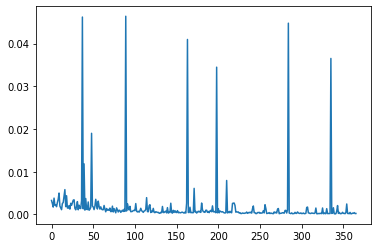

In [297]:
# X-axis: training steps, Y-axis: training loss
pd.Series(train_loss_history).plot()

## Plot Validation Accuracy Curve

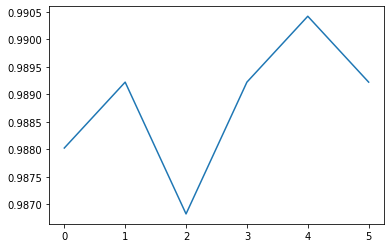

In [298]:
# X-axis: Epochs, Y-axis: validation accuracy
pd.Series(val_accuracy_history).plot()

## Test the model on Test DataLoader

In [299]:
# reload the best model
best_model = torch.load("best_model.pt")
test_accuracy = evaluate(model, test_loader, device)
print(test_accuracy)

0.9916167664670659


## Detailed Analysis of the Model

### Prepare a batch

In [236]:
# We only use one batch to trace the output of each part of model
data_batch, label_batch = next(iter(train_loader))

### Prepare a model

In [237]:
# 01: Create Embedding Layer
embedding_layer = nn.Embedding(embeddings.shape[0],embeddings.shape[1], padding_idx=0)

In [238]:
embedding_layer.weight.data = torch.Tensor(embeddings).float()

In [239]:
# 02: Create Dropout Layer, with dropout probability 0.3
dropout = nn.Dropout(p=0.3)

In [240]:
# 03: Create lstm Layer
hidden_size = 25
lstm = nn.LSTM(input_size=300, # which is the embedding dimesion
               hidden_size=hidden_size, # which is the size of h in lstm
               num_layers=1,   # number of lstm layer is one
               batch_first=True,
               bidirectional=True)

In [241]:
# 04: Create non linear layer
non_linearity = nn.ReLU()

In [242]:
# 05: Create classification layer
clf = nn.Linear(hidden_size, 2) # hiddensize, and num of classes

### See the output of each layer

In [243]:
logits = None

In [244]:
embedding_out = embedding_layer(data_batch)

![](images/003.png)

In [245]:
lstm_out, (h_n, c_n) = lstm(embedding_out)
lstm_forward_out = lstm_out[:,:,:hidden_size]
lstm_backward_out= lstm_out[:,:,hidden_size:]

In [246]:
lstm_out.shape

torch.Size([64, 77, 50])

![](images/004.jpg)

In [247]:
stacked_lstm_out = torch.stack([lstm_forward_out, lstm_backward_out])

In [248]:
stacked_lstm_out.shape

torch.Size([2, 64, 77, 25])

In [249]:
dim_2_max, _ = torch.max(stacked_lstm_out, dim=2)

In [250]:
dim_0_max, _ = torch.max(dim_2_max, dim=0)

In [251]:
dim_0_max.shape

torch.Size([64, 25])

![](images/005.png)

In [252]:
# turn each negative number to zero
non_linearity_out = non_linearity(dim_0_max)

In [253]:
logits = clf(non_linearity_out)

In [254]:
logits.shape

torch.Size([64, 2])

### Evaluate Cross Entrophy

In [256]:
loss = criterion(logits, label_batch)

In [257]:
loss

tensor(0.6580, grad_fn=<NllLossBackward>)

In [260]:
loss.backward()

In [261]:
optimizer.step()
optimizer.zero_grad()